### Trying GPy
    - plotting issue using plotly
    - GPLVM and Bayesian GPLVM
    - how optimization works in both cases?
    - what makes it Bayesian ?
    - what is the improvement for Bayesian approach
    - how can it be extended

In [2]:
# ! pip install gpy

    100% |████████████████████████████████| 880kB 19.6MB/s 
    100% |████████████████████████████████| 71kB 17.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/82/1d/32a361e1ff2b4d9129a60343831dd99cdc74440e2db1c55264
  Stored in directory: /root/.cache/pip/wheels/a9/fc/74/3bbd263c43ed98d67343df24cebf0a0ee34afee40d769fda9c
Successfully built gpy paramz


In [0]:
# import plotly

In [0]:
import numpy as np
# import pymc as pm
import GPy 
import matplotlib.pyplot as plt
GPy.plotting.change_plotting_library('plotly')

In [0]:
# Define dataset 
N = 100
k1 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,10,10,0.1,0.1]), ARD=True)
k2 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,0.1,10,0.1,10]), ARD=True)
k3 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[0.1,0.1,10,10,10]), ARD=True)
X = np.random.normal(0, 1, (N, 5))
A = np.random.multivariate_normal(np.zeros(N), k1.K(X), 10).T
B = np.random.multivariate_normal(np.zeros(N), k2.K(X), 10).T
C = np.random.multivariate_normal(np.zeros(N), k3.K(X), 10).T

Y = np.vstack((A,B,C))
labels = np.hstack((np.zeros(A.shape[0]), np.ones(B.shape[0]), np.ones(C.shape[0])*2))

input_dim = 2 # How many latent dimensions to use
kernel = GPy.kern.RBF(input_dim, 1, ARD=True) 


In [5]:
A.shape, B.shape, C.shape, Y.shape

((100, 10), (100, 10), (100, 10), (300, 10))

In [0]:
from sklearn.decomposition import PCA

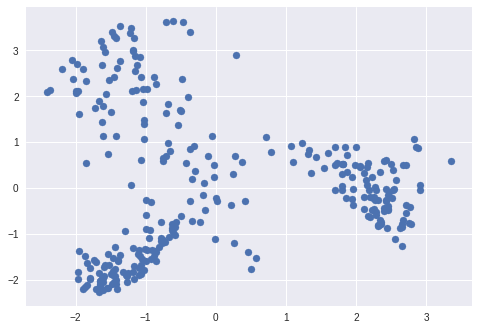

In [7]:
pca= PCA(n_components=2)
y_test = pca.fit_transform(Y)

plt.scatter(y_test[:,0], y_test[:,1])

In [8]:
Q = input_dim
m_gplvm = GPy.models.GPLVM(Y, Q, kernel=GPy.kern.RBF(Q))
m_gplvm.kern.lengthscale = .2
m_gplvm.kern.variance = 1
m_gplvm.likelihood.variance = 1.
#m2.likelihood.variance.fix(.1)
m_gplvm

GPLVM.,value,constraints,priors
latent_mean,"(300, 2)",,
rbf.variance,1.0,+ve,
rbf.lengthscale,0.2,+ve,
Gaussian_noise.variance,1.0,+ve,


In [9]:
m_gplvm.optimize(messages=1, max_iters=5e4)

In [16]:
figure = GPy.plotting.plotting_library().figure(1, 2, 
                        shared_yaxes=True,
                        shared_xaxes=True,
                        subplot_titles=('Latent Space', 
                                        'Magnification',
                                        )
                            )


canvas = m_gplvm.plot_latent(labels=labels, figure=figure, col=(1), legend=False)
canvas = m_gplvm.plot_magnification(labels=labels, figure=figure, col=(2), legend=False)

GPy.plotting.show(canvas, filename='wishart_metric_notebook')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]



/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




ValueError: ignored

### Trying PyMC implementation
    - how it performs optimization
    - uses trace ? what does it mean
    - how can it be extended?

In [0]:
import sys

import pymc3 as pm
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

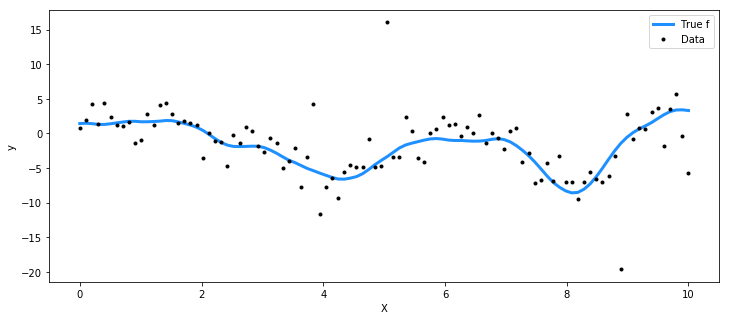

In [0]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

In [0]:
# with pm.Model() as model:
#     ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
#     η = pm.HalfCauchy("η", beta=5)

#     cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     gp = pm.gp.Latent(cov_func=cov)

#     f = gp.prior("f", X=X)
    
#     σ = pm.HalfCauchy("σ", beta=5)
#     ν = pm.Gamma("ν", alpha=2, beta=0.1)
#     y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)
#     print("here")
#     trace = pm.sample(10)

In [0]:
print(X.shape)

(100, 1)


In [0]:
with pm.Model() as model:
    X_ = pm.Normal("X", mu = X.mean(), sd = X.std(), shape = 100, observed= True)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)
    print("here")
    trace = pm.sample(10, tune = 10)

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


here


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, f_rotated_, η, ℓ]
Sampling 2 chains: 100%|██████████| 40/40 [00:17<00:00,  2.26draws/s]
/home/arnav/miniconda3/lib/python3.6/site-packages/pymc3/sampling.py:466: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [0]:
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[X_], samples=1000, size = 1000)


print(pred_samples['X'].shape)
dat_mean, dat_std = pred_samples['X'].mean(),pred_samples['X'].std()
(dat_mean,dat_std) ,(X.mean(), X.std())

100%|██████████| 1000/1000 [00:00<00:00, 2006.94it/s]


(1000, 1000)


((5.002411227111469, 2.914302863759382), (5.0, 2.9157646512850626))

^^ the above shows that we can resample the input

how to do it given the params?

write the marginal of X in terms of Y and set Y=observed and try if time

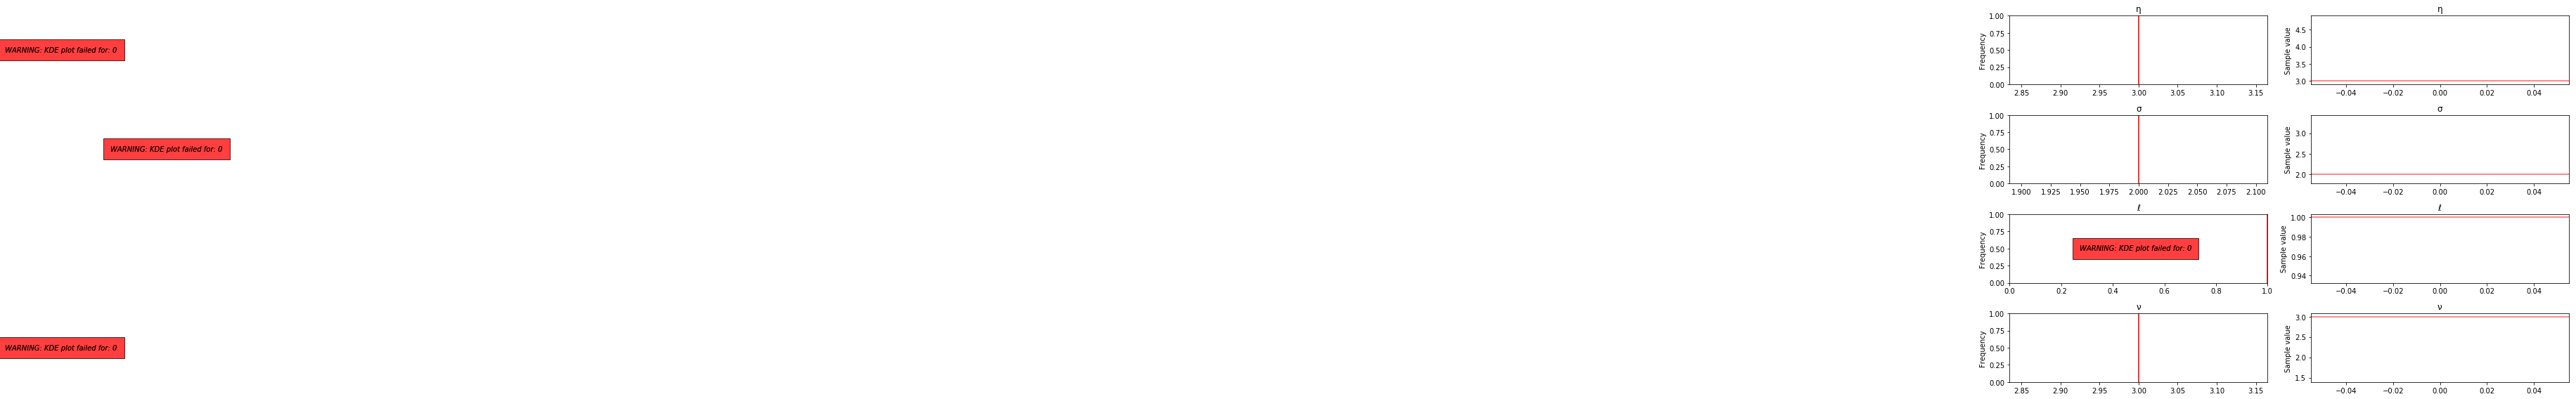

In [0]:
pm.traceplot(trace, lines={"η": η_true, "σ": σ_true, "ℓ": ℓ_true, "ν": ν_true}, varnames=["η", "σ", "ℓ", "ν"]);

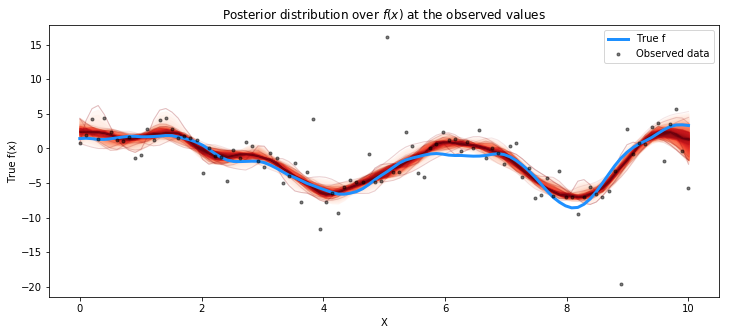

In [0]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [0]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)



100%|██████████| 1000/1000 [01:19<00:00, 12.57it/s]


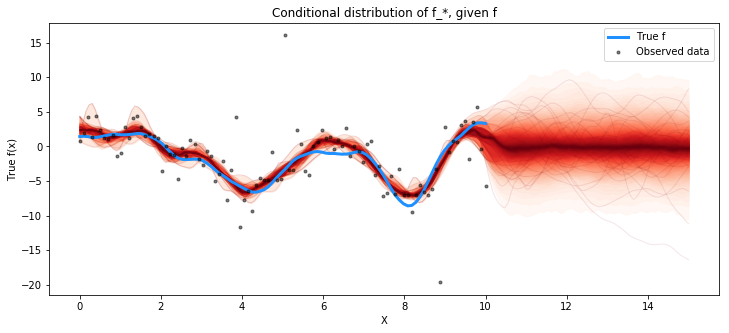

In [0]:

# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();

{'f_pred': array([[ 3.40192797,  3.45024769,  3.4136014 , ...,  2.39702219,
          3.29866343,  4.04188717],
        [ 2.88494901,  2.52414298,  2.26525973, ..., -4.3606087 ,
         -4.37894503, -4.42346404],
        [ 2.46457777,  2.46536618,  2.47215747, ...,  0.40306602,
          1.17408017,  1.78609591],
        ...,
        [ 4.22996617,  3.79557982,  3.35966153, ..., -2.18671487,
         -2.45004651, -2.89640482],
        [ 2.8789624 ,  2.60649128,  2.48169832, ..., -2.90329394,
         -2.74128724, -2.72869213],
        [ 3.25770365,  3.09712956,  3.07255078, ...,  0.32208833,
          0.4420627 ,  0.48311644]])}

### Trying GPflow
    - tf implementation of GPy
    - faster and better for larger models
    
    - mostly using this in the project
    - train a B-GPLVM on some data and show results
    - repeat on MNIST
    - reproduce some results--> class separation etc

In [0]:
! pip install gpflow

    100% |████████████████████████████████| 256kB 8.9MB/s 


In [0]:
import gpflow as gp

In [0]:
import gpflow
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
np.random.seed(42)
gpflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

In [0]:
data = np.loadtxt('data/DataTrn.txt')
labels_ = np.loadtxt("data/DataTrnLbls.txt")
Y = data
# labels = data['labels']

# print('Number of points x Number of dimensions', Y.shape)


OSError: ignored

In [0]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]

fHmmm = False
if(fHmmm):
    k = (kernels.RBF(3, ARD=True, active_dims=slice(0,3)) +
         kernels.Linear(2, ARD=False, active_dims=slice(3,5)))
else:
    k = (kernels.RBF(3, ARD=True, active_dims=[0,1,2]) +
         kernels.Linear(2, ARD=False, active_dims=[3, 4]))

m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

opt = gpflow.train.ScipyOptimizer()
m.compile()
opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(10000))

/home/arnav/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -5535.574334
  Number of iterations: 1663
  Number of functions evaluations: 1767


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -5535.574334
  Number of iterations: 1663
  Number of functions evaluations: 1767


In [0]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/kern/kernels/0/lengthscales,Parameter,None,+ve,True,"(3,)",True,"[5.717519832562978, 69.94117024188954, 1.61438..."
BayesianGPLVM/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,21.638272060813293
BayesianGPLVM/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,0.027213507953804825


In [0]:
kern = m.kern.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)

[0.81358627 0.06650869 2.88141104]


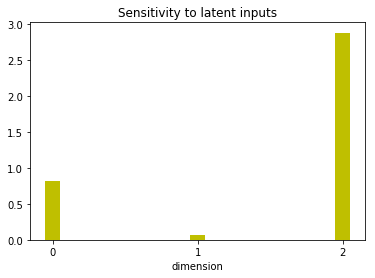

In [0]:
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.1, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');

In [0]:
dim1, dim2 = sens.argsort()[::-1][:2]  # the two dimensions with highest sensitivity

In [0]:
labels = [l.argmax() for l in labels_]

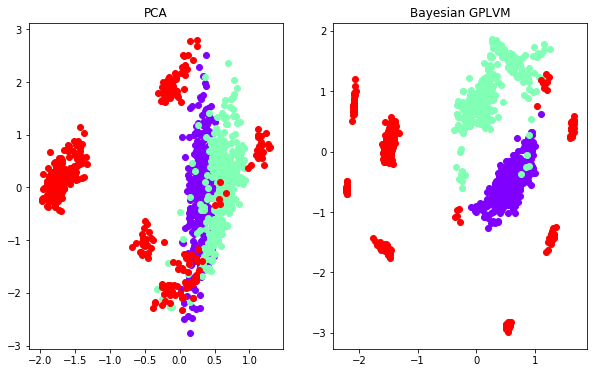

In [0]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i, 0], XPCAplot[labels==i, 1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(GPLVM_X_mean[labels==i, dim1], GPLVM_X_mean[labels==i, dim2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM')

## TODO:
    - evaluation of representations code
    - same on mnist
    - partially obdserverd reconstructions
    

In [0]:
# reconstruction error based only on the mean predictions
# mean Y | X
((m.predict_y(GPLVM_X_mean[:,:])[0] - Y[:,:])**2).sum(axis = 1).mean()

0.01900653752975054

In [0]:
# f | x
m.predict_f(GPLVM_X_mean[0].reshape(1,5))

(array([[0.31762794, 0.15113056, 0.64923904, 0.21047601, 0.72054584,
         0.24760859, 0.66996562, 0.20628934, 0.74849885, 0.24887449,
         0.59426458, 0.18852404]]),
 array([[5.46845812e-05, 5.46845812e-05, 5.46845812e-05, 5.46845812e-05,
         5.46845812e-05, 5.46845812e-05, 5.46845812e-05, 5.46845812e-05,
         5.46845812e-05, 5.46845812e-05, 5.46845812e-05, 5.46845812e-05]]))

In [0]:
##log lokelihood of Y_new | x_new
m.predict_density(GPLVM_X_mean[1].reshape(1,5), Y[0].reshape(1,12)).sum()

-570.6220406957914

In [0]:
GPLVM_X_mean[0]

array([-1.14369628, -0.01698357,  0.37374261,  0.02351539, -0.78905761])

In [0]:
## find X_new | Y_new ??


### same on MNIST

In [23]:
! pip install gpflow

    100% |████████████████████████████████| 256kB 16.2MB/s 


In [0]:
import gpflow
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
np.random.seed(42)
gpflow.settings.numerics.quadrature = 'error' 
import torch, torchvision
import torchvision.transforms as transforms
root = './data'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [0]:
from tqdm import tqdm_notebook as tqdm

In [25]:
MNIST_train = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
MNIST_test  = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

100%|█████████▉| 9871360/9912422 [00:11<00:00, 617729.89it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


32768it [00:00, 131126.40it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz



 98%|█████████▊| 1613824/1648877 [00:03<00:00, 343214.72it/s]
1654784it [00:03, 425974.90it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 49102.11it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


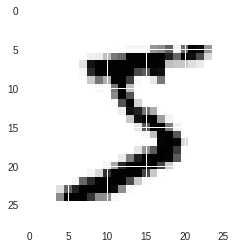

In [26]:
plt.imshow(MNIST_train[0][0].reshape(28,28))

(<matplotlib.image.AxesImage at 0x7f682e8305c0>, 7)

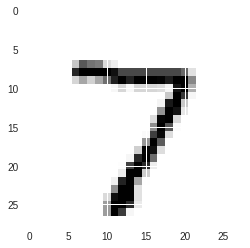

In [27]:
plt.imshow(MNIST_test[0][0].reshape(28,28)), MNIST_test[0][1]

In [28]:
 MNIST_train[0][1]

5

In [0]:
x = []
labels = []
for t, l in MNIST_train:
    x.append(t.numpy().flatten())
    labels.append(l)

In [0]:
x = np.array(x)
labels = np.array(labels)

In [31]:
x.shape

(60000, 784)

In [0]:
x_3 = x[np.where(labels <= 1)]
l_3 = labels[np.where(labels <= 1)]

In [33]:
Y = x_3.astype(np.float64)
Y.shape

(12665, 784)

In [0]:
del x

In [0]:
## making gpflow kernels
k_test = kernels.RBF(5,ARD=True, active_dims=[0,1,2, 3, 4])

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
k_test.compute_K(np.ones((5, 1)),2* np.ones((5, 1)))    

array([[0.60653066, 0.60653066, 0.60653066, 0.60653066, 0.60653066],
       [0.60653066, 0.60653066, 0.60653066, 0.60653066, 0.60653066],
       [0.60653066, 0.60653066, 0.60653066, 0.60653066, 0.60653066],
       [0.60653066, 0.60653066, 0.60653066, 0.60653066, 0.60653066],
       [0.60653066, 0.60653066, 0.60653066, 0.60653066, 0.60653066]])

In [0]:
Q = 50
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:20]
X_mean.shape, Z.shape

((12665, 50), (20, 50))

In [35]:
Q = 20
M = 100  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA # other initializations?
Z = np.random.permutation(X_mean.copy())[:M]

fHmmm = True
if(fHmmm):
    k = kernels.RBF(20, ARD=True, active_dims=slice(0,20)) #+
         #kernels.Linear(5, ARD=False, active_dims=slice(5,10)))
else:
    k = (kernels.RBF(5, ARD=True, active_dims=[0, 1, 2, 3, 4]) +
         kernels.Linear(2, ARD=False, active_dims=[5, 6]))

m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

opt = gpflow.train.ScipyOptimizer()
# opt = gpflow.train.AdamOptimizer()
m.compile()
opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(1))
print("done")


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 169316456.428453
  Number of iterations: 1
  Number of functions evaluations: 2


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 169316456.428453
  Number of iterations: 1
  Number of functions evaluations: 2


done


In [42]:
m

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/X_mean,Parameter,None,(none),True,"(12665, 20)",True,"[[0.12293089412968489, 0.7057775699273741, 0.3..."
BayesianGPLVM/X_var,Parameter,None,+ve,True,"(12665, 20)",True,"[[0.0999999998526396, 0.0999999998926909, 0.09..."
BayesianGPLVM/feature/Z,Parameter,None,(none),True,"(100, 20)",True,"[[0.21910375938830895, -0.8638505215275861, -0..."
BayesianGPLVM/kern/lengthscales,Parameter,None,+ve,True,"(20,)",True,"[1.0036212880489899, 1.00387682292626, 1.00365..."
BayesianGPLVM/kern/variance,Parameter,None,+ve,True,(),True,0.721025690499868
BayesianGPLVM/likelihood/variance,Parameter,None,+ve,True,(),True,0.02378324836643355


In [0]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/kern/lengthscales,Parameter,None,+ve,True,"(20,)",True,"[47.02839567330168, 42.838560242026, 43.919333..."
BayesianGPLVM/kern/variance,Parameter,None,+ve,True,(),True,3.5949414500407144


In [0]:
kern = m.kern#.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)

[0.04031677 0.04425996 0.04317081 0.03396238 0.04035516 0.03448333
 0.03758239 0.03788173 0.04882216 0.03582734 0.03843735 0.03296911
 0.03442503 0.04148951 0.07198673 0.06005101 0.06967934 0.04989496
 0.07554849 0.06892469]


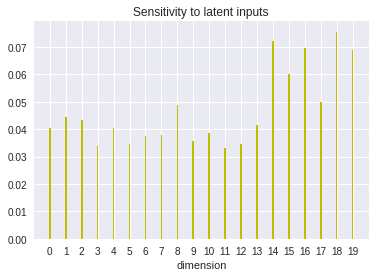

In [0]:
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.1, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');

In [0]:
dim1, dim2 = sens.argsort()[::-1][:2] 

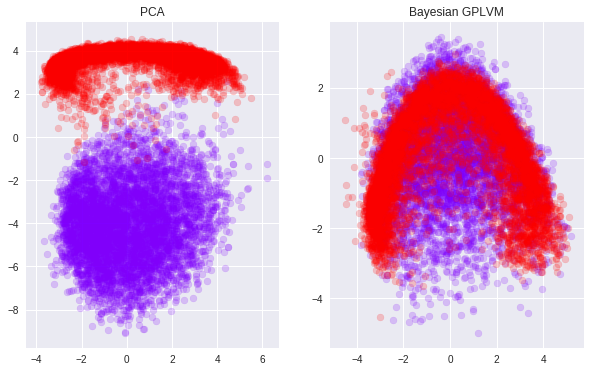

In [0]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(l_3))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[l_3==i, 0], XPCAplot[l_3==i, 1], color=c, label=i, alpha = 0.2)
    ax[0].set_title('PCA')
    ax[1].scatter(GPLVM_X_mean[l_3==i, dim1], GPLVM_X_mean[l_3==i, dim2], color=c, label=i, alpha = 0.2)
    ax[1].set_title('Bayesian GPLVM')

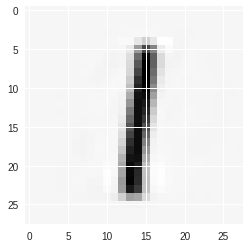

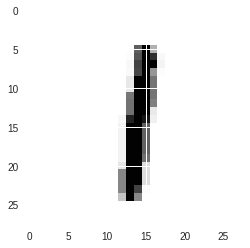

In [0]:
def reconstruct(Q, i):
    y = m.predict_y(GPLVM_X_mean[i].reshape(1,Q))[0]  #returns (mean, vars)

    plt.imshow(y.reshape(28,28))
#     plt.savefig("reconstruction"+str(i) + ".png")
    plt.figure()
    plt.imshow(Y[i].reshape(28,28))
#     plt.savefig("actual" +str(i) + ".png")
reconstruct(Q, i=10)

In [0]:
(GPLVM_X_mean[i].reshape(1,Q)[0] + np.random.randn(1,Q)).shape

(1, 20)

### Experimetns
    - look at how kernel composition works
    - how to scale up to deeper models
    - how to train deep models? layer by layer? together?
        - layer by layer doesnt seem to work that well
                somehow learns one class between 0 and 1 and always reconstructs that
                more iters/ smaller lr/ others
              
              #### ensure that GPU is being used
              
        - maybe look at GPy to extend
        - stack deep models using tf: 
            https://gist.github.com/marta-sd/ba47a9626ae2dbcc47094c196669fd59
            
            https://www.reddit.com/r/learnmachinelearning/comments/7ksv31/tensorflow_concatenate_two_subgraphs_in_a_big/
            
    - can I use pytorch to do this thing?
        - maybe after stacking and saving
  
    - look at the optimizers to use
    - other initializations
    
    
    

In [0]:
# assume reshaping etc done outside model

class DeepGPLVM:
    def __init__(self,kernel_dim = 5, n_layers=2, inducing_pts=100, latent_dim=20, max_iters=10):
        self.kernel = kernels.RBF(kernel_dim, ARD=True, active_dims=slice(0,kernel_dim))
        self.latent_dim = latent_dim
        self.inducing_pts = inducing_pts
        self.n_layers = n_layers
        self.max_iters = max_iters
        
    def train(self, Y):
        self.models = []
        M = self.inducing_pts
        Q = self.latent_dim
        X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA # other initializations?
        Z = np.random.permutation(X_mean.copy())[:M]
        opt = gpflow.train.ScipyOptimizer()

        for i in range(self.n_layers):
            m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=self.kernel, M=M, Z=Z)
            m.likelihood.variance = 0.01
            m.compile()
        
            opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(self.max_iters))
            self.models.append(m) 
#             print(m.X_mean.shape)
            Y = X_mean 
#             X_mean, X_var = m.predict_y(X_mean)
#             X_mean = gpflow.models.PCA_reduce(Y, Q)
            Z = np.random.permutation(X_mean.copy())[:M]
        # test layer by layer backwards
        
        # connect graphs and see if it works ??
        # test fine tune performance vs all together
            # write code for this
            # use tf / torch  + cross entropy [0,1]
        self.means = X_mean
        
    def reconstruct(self, idx):
        x_mean = self.means[idx].reshape(1, self.latent_dim)
        for model in reversed(self.models):
            x_recon = model.predict_y(x_mean)[0]
#             plt.figure()
#             plt.imshow(x_recon.reshape(28,28))
            x_mean = x_recon
        
        return x_recon
    
    def predict_likelihoods(self, X, Y):
        pass

In [0]:
dgp = DeepGPLVM(n_layers = 2, max_iters=10)
Y = x_3.astype(np.float64)
dgp.train(Y)

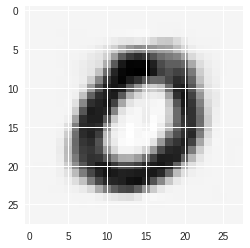

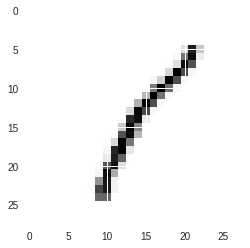

In [199]:
# GPLVM_X_mean = m.X_mean.read_value()
# recon = dgp.reconstruct(GPLVM_X_mean[6].reshape(1,Q))
i=-1
recon = dgp.reconstruct(i)
plt.figure()
plt.imshow(recon.reshape(28,28))
plt.figure()
plt.imshow(Y[i].reshape(28,28))

In [0]:
i = 0
recs = []
x_mean = dgp.means[i].reshape(1, dgp.latent_dim)
for model in reversed(dgp.models):
    x_recon = model.predict_y(x_mean)[0]
    print(x_recon.shape)
    recs.append(x_recon)
    x_mean = x_recon

plt.figure()
plt.imshow(recs[0].flatten().reshape(4,5))

plt.figure()
plt.imshow(recs[1].flatten().reshape(28,28))

plt.figure()
plt.imshow(Y[i].reshape(28,28))

In [218]:
idxs = np.random.randint(0, Y.shape[0],10)#np.random.permutation(dgp.means)[:10]

random_sample = dgp.means[idxs]

plt.figure()
for i, idx in enumerate(idxs,1):
    rec= dgp.reconstruct(idx)
    plt.subplot(2,5,i)
    plt.imshow(rec.flatten().reshape(28, 28))

plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.imshow(y.flatten().reshape(28, 28))

    
plt.figure()
for i, mean in enumerate(random_sample, 1):
    plt.subplot(2,5,i)
    plt.imshow(mean.flatten().reshape(5,4))

AttributeError: ignored

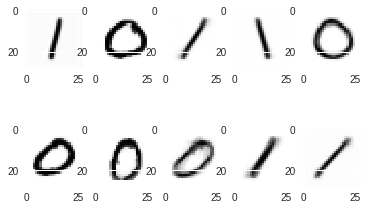

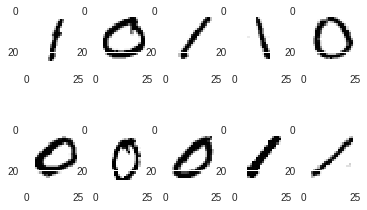

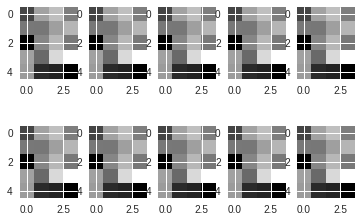

In [215]:
plt.figure()
for i, idx in enumerate(idxs,1):
    rec= m.predict_y(GPLVM_X_mean[idx].reshape(1,20))[0]
    plt.subplot(2,5,i)
    plt.imshow(rec.flatten().reshape(28, 28))

plt.figure()
for i, y in enumerate(Y[idxs],1):
    plt.subplot(2,5,i)
    plt.imshow(y.flatten().reshape(28, 28))

    
plt.figure()
for i, mean in enumerate(idxs, 1):
    plt.subplot(2,5,i)
    plt.imshow(GPLVM_X_mean[idx].flatten().reshape(5,4))

In [0]:
# m1 = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
#                                 kern=k, M=M, Z=Z)
# m1.likelihood.variance = 0.01
# m1.compile()

# m2 = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
#                                 kern=k, M=M, Z=Z)
# m2.likelihood.variance = 0.01
# m2.compile()


In [0]:
# g1 = m1.graph
# g2 = m2.graph

In [0]:
# import tensorflow as tf

In [0]:
# g3 = tf.Graph()
# with g3.as_default():
# #      tf.train.import_meta_graph('g1.meta', import_scope='g1')
# #     out = g1.g1.get_tensor_by_name('')
#     out = [g3.get_tensor_by_name('g1/%s:0' % name) for name in ('BayesianGPLVM/X_mean',)][0]
     

In [0]:
# m.feature

In [0]:
# for n in g1.as_graph_def().node:
#     if 'feature/Z' in n.name:
#         print(n.name)